In [1]:
!pip install ipython-autotime
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 8.4 MB/s eta 0:00:01


In [2]:
%matplotlib inline
%load_ext autotime

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from utils import MultipleTimeSeriesCV, format_time

sns.set_style('whitegrid')
#np.random.seed(42) # for consistent cv
idx = pd.IndexSlice


time: 2.33 s (started: 2021-05-01 02:18:54 +00:00)


In [3]:
# ignore following
# /opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
#  _log_warning('Overriding the parameters from Reference Dataset.')
import warnings
warnings.filterwarnings('ignore')

time: 593 µs (started: 2021-05-01 02:18:56 +00:00)


In [4]:
### set path
import os
from pathlib import Path
path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
path_result = path_home / 'result'

time: 762 µs (started: 2021-05-01 02:19:13 +00:00)


In [5]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_result.zip .
!unzip stooq_jp_result.zip

Copying gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip...
- [1 files][401.4 MiB/401.4 MiB]                                                
Operation completed over 1 objects/401.4 MiB.                                    
Archive:  stooq_jp_data.zip
  inflating: data/stooq_jp_tse_stocks_prices.csv  
  inflating: data/stooq_jp_tse_stocks_tickers.csv  
  inflating: data/stooq_jp_equities.csv  
Copying gs://finance_data_bucket/lbk/rf/stooq_jp_result.zip...
- [1 files][ 47.4 MiB/ 47.4 MiB]                                                
Operation completed over 1 objects/47.4 MiB.                                     
Archive:  stooq_jp_result.zip
  inflating: result/lin_reg_performance.csv  
  inflating: result/test_01.csv      
time: 29.1 s (started: 2021-05-01 02:19:17 +00:00)


In [6]:
YEAR = 252
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
val_length = 2 * YEAR

time: 769 µs (started: 2021-05-01 02:20:13 +00:00)


In [7]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

time: 870 µs (started: 2021-05-01 02:20:14 +00:00)


In [8]:
cpu_count = os.cpu_count()
print('# of cpus:', cpu_count)

base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   n_jobs=cpu_count,
                   verbose=-1)

# of cpus: 2
time: 2.08 ms (started: 2021-05-01 02:20:15 +00:00)


In [10]:
daily_ic_avg = pd.read_csv(path_result / 'daily_ic_avg.csv')
daily_ic_avg.head()

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
0,1,63,5,0.5,0.75,250,25,0.005485
1,1,63,5,0.5,0.75,250,50,0.004826
2,1,63,5,0.5,0.75,250,75,0.005358
3,1,63,5,0.5,0.75,250,100,0.004369
4,1,63,5,0.5,0.75,250,125,0.003739


time: 38.3 ms (started: 2021-05-01 02:25:33 +00:00)


In [23]:
train_start_year = '2012'
data = (pd.read_csv(path_data / 'stooq_jp_equities.csv', parse_dates=['date'])
          .set_index(['ticker','date'])
          .sort_index(level=['ticker','date'])
          .loc[idx[:, '2012':], :]
          )
data.tail()

ret_1  ret_rel_perc_1     ret_5  ret_rel_perc_5  \
ticker  date                                                             
9990.JP 2019-12-24  0.000000             9.0  0.000000            14.0   
        2019-12-25 -0.009687             7.0 -0.007535            12.0   
        2019-12-26  0.001071             3.0 -0.016025             4.0   
        2019-12-27  0.000000             4.0 -0.010749             5.0   
        2019-12-30 -0.003257            15.0 -0.011856             5.0   

                      ret_10  ret_rel_perc_10    ret_21  ret_rel_perc_21  \
ticker  date                                                               
9990.JP 2019-12-24  0.020886             15.0  0.026531             12.0   
        2019-12-25  0.010997             14.0  0.027940             14.0   
        2019-12-26  0.013201             12.0  0.019933             12.0   
        2019-12-27  0.010960             13.0  0.012080              9.0   
        2019-12-30  0.007668             15.0  0.008783              9.0   

                      ret_63  ret_rel_perc_63  ...       bbl       bbu  \
ticker  date                                   ...                       
9990.JP 2019-12-24  0.035690              6.0  ...  1.005136  1.008108   
        2019-12-25  0.008788              4.0  ...  1.001469  1.021021   
        2019-12-26  0.009868              4.0  ...  1.004487  1.015347   
        2019-12-27  0.017675              5.0  ...  1.005675  1.012177   
        2019-12-30  0.023411              5.0  ...  1.004078  1.012353   

                    weekday  month  year  fwd_ret_01  fwd_ret_05  fwd_ret_10  \
ticker  date                                                                   
9990.JP 2019-12-24        1     12  2019   -0.009687         NaN         NaN   
        2019-12-25        2     12  2019    0.001071         NaN         NaN   
        2019-12-26        3     12  2019    0.000000         NaN         NaN   
        2019-12-27        4     12  2019   -0.003257         NaN         NaN   
        2019-12-30        0     12  2019         NaN         NaN         NaN   

                    fwd_ret_21  fwd_ret_63  
ticker  date                                
9990.JP 2019-12-24         NaN         NaN  
        2019-12-25         NaN         NaN  
        2019-12-26         NaN         NaN  
        2019-12-27         NaN         NaN  
        2019-12-30         NaN         NaN  

[5 rows x 23 columns]

time: 14 s (started: 2021-05-01 02:44:28 +00:00)



Lookahead: 01
Position: 00
Position: 01
Position: 02
Position: 03
Position: 04
Position: 05
Position: 06
Position: 07
Position: 08
Position: 09


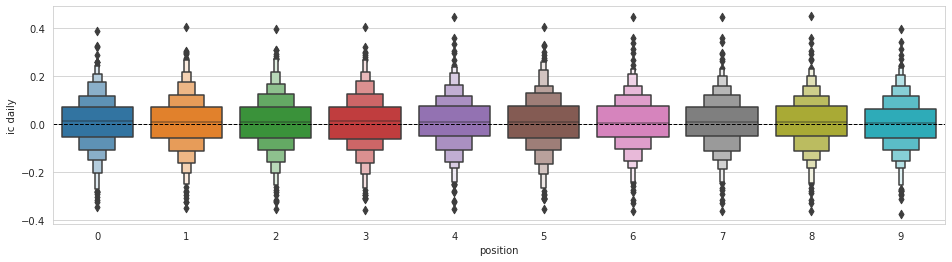

time: 11min 2s (started: 2021-05-01 02:57:00 +00:00)


In [27]:
num_models = 10
lookaheads = [1, 5, 10, 21]
lookaheads = lookaheads[:1]

for lookahead in lookaheads:
    print(f'\nLookahead: {lookahead:02}')
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.loc[:, features + [label]]

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(num_models):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'Position: {position:02}')

        n_splits = int(val_length / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            train_set = lgb_data.subset(used_indices=train_idx.tolist(),
                                        #params=params).construct()
                                        params=params)
    
            model = lgb.train(params=params,
                              train_set=train_set,
                              num_boost_round=num_boost_round,
                              categorical_feature=categoricals, 
                              verbose_eval=False)
        
            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))
            #train_test_perdios_msg(train_idx, test_idx, data)
            
        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        
    by_day = test_predictions.groupby(level='date')
    for position in range(num_models):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
    test_predictions = test_predictions.sort_index(level=['ticker','date'])
    test_predictions.to_csv(path_result / f'test_{lookahead:02}.csv')

# plot ic
fig, ax = plt.subplots(figsize=(min(int(num_models*3),16), 4))
sns.boxenplot(x='position', y='ic daily', 
                   data=pd.melt(ic_by_day).rename(columns={'variable':'position', 'value':'ic daily'}),
                   ax=ax )
ax.axhline(0, ls='--', lw=1, c='k');

In [28]:
test_predictions.tail()

y_test         0         1         2         3  \
ticker  date                                                           
9990.JP 2019-12-24 -0.009687 -0.006871 -0.006826 -0.006793 -0.006643   
        2019-12-25  0.001071 -0.006888 -0.006832 -0.006776 -0.006666   
        2019-12-26  0.000000 -0.006443 -0.006618 -0.006595 -0.006421   
        2019-12-27 -0.003257 -0.008313 -0.008349 -0.008349 -0.008121   
        2019-12-30       NaN  0.002975  0.003271  0.003264  0.003251   

                           4         5         6         7         8         9  
ticker  date                                                                    
9990.JP 2019-12-24 -0.008683 -0.006633 -0.008968 -0.009191 -0.009262 -0.011793  
        2019-12-25 -0.001600 -0.006635 -0.001852 -0.002043 -0.002001 -0.001620  
        2019-12-26 -0.008621 -0.006456 -0.008920 -0.009173 -0.009240 -0.011767  
        2019-12-27 -0.007027 -0.008069 -0.007333 -0.007502 -0.007550 -0.009309  
        2019-12-30  0.002325  0.003339  0.002015  0.001839  0.001921  0.003311

time: 17.9 ms (started: 2021-05-01 03:29:10 +00:00)


In [38]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 15

time: 481 µs (started: 2021-05-01 03:42:57 +00:00)


In [56]:
positions = 5
#test_predictions.iloc[:, :positions].mean(1).to_frame('predictions').unstack('date').iloc[:,-5:].apply(lambda x: x.nlargest(N_LONGS, keep='all'))
#test_predictions.iloc[:, :positions].mean(1).to_frame('predictions').unstack('date').iloc[:,-1].gt(0).nlargest(N_LONGS, keep='all')

long = test_predictions.iloc[:, :positions].mean(1).to_frame('predictions').unstack('date').iloc[:,-1]
long.loc[long.gt(0)].nlargest(N_LONGS, keep='all')

ticker
6875.JP    0.006827
7956.JP    0.006827
9678.JP    0.006803
3254.JP    0.006646
6779.JP    0.006646
6803.JP    0.006622
8614.JP    0.006590
2428.JP    0.006465
9987.JP    0.006465
8613.JP    0.006426
4028.JP    0.006357
7518.JP    0.006260
4331.JP    0.006260
4343.JP    0.006245
6966.JP    0.005817
3064.JP    0.005355
1959.JP    0.005075
4088.JP    0.005075
4922.JP    0.005075
7731.JP    0.005075
6908.JP    0.004620
7205.JP    0.003716
2353.JP    0.003667
8107.JP    0.003656
9706.JP    0.003610
Name: (predictions, 2019-12-30 00:00:00), dtype: float64

time: 121 ms (started: 2021-05-01 05:46:45 +00:00)


In [63]:
#test_predictions.iloc[:, :positions].mean(1).to_frame('predictions').unstack('date').iloc[:,-1].nsmallest(N_SHORTS, keep='all')
short = test_predictions.iloc[:, :positions].mean(1).to_frame('predictions').unstack('date').iloc[:,-2]
short.loc[short.lt(0)].nsmallest(N_SHORTS, keep='all')

ticker
2685.JP   -0.020338
7647.JP   -0.020315
2398.JP   -0.016046
6324.JP   -0.015930
4565.JP   -0.015501
7611.JP   -0.014431
2706.JP   -0.014349
7287.JP   -0.014302
4045.JP   -0.014049
2120.JP   -0.013961
8358.JP   -0.013746
8360.JP   -0.013300
7864.JP   -0.013261
8107.JP   -0.013246
8363.JP   -0.013086
2440.JP   -0.012983
8508.JP   -0.012959
4461.JP   -0.012811
9543.JP   -0.012795
8125.JP   -0.012793
7606.JP   -0.012575
8397.JP   -0.012397
8368.JP   -0.012321
9869.JP   -0.012128
2428.JP   -0.012086
Name: (predictions, 2019-12-27 00:00:00), dtype: float64

time: 125 ms (started: 2021-05-01 05:48:42 +00:00)
